43.64406001677774
0.18581883623275344
8.98443603515625


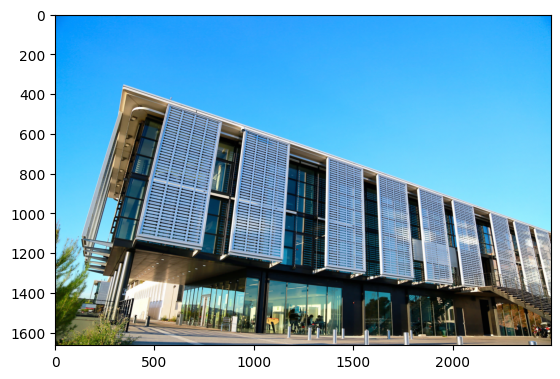

In [3]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()
#defintion des données nécessaires à la DCT à savoir la matrice de passage, les blocs de matrice 8*8 relatif à chaque couleur et à la compression à savoir la matrice de Quantification.
#il faut tout d’abord décomposer la matrice de l’image à des blocs 
def decomposition8x8(M):
    n=np.shape(M)[0]
    k=np.shape(M)[1]
    Bloc=[]
    for i in range(0,n,8):
        for j in range(0,k,8):
            Bloc.append(M[i:i+8,j:j+8])
#on ajoute des matrices de 8x8 au tableau de matrices qu’on a nommé bloc
    return Bloc

Pm=np.zeros((8,8))
for i in range(8):
    for j in range(8):
        Pm[i,j]=(1/2)*m.cos((2*j+1)*i*m.pi/16)

Pm[0,:]*=1/m.sqrt(2) #C0=1/sqrt(2) #normalisation 

# la matrice de quantification Q varie d’un cas à un autre et pourra prendre plusieurs valeurs selon le degré de la compression , donc elle fera partie des entrées de la fonction compression
# On appliquera la fonction de compression aux matrices de couleurs extraites de la matrice originale liée à l'image que l'on comprimera qu’on notera respectivement MR , MB , MG relative au rouge , bleu et vert de taille 8*8   
def compression(M,Pm,Q):
    #P=Pass_Matrix(n)
    D=np.zeros((8,8))
    #application de DCT
    D=np.matmul(Pm,M)
    D=np.matmul(D,np.transpose(Pm))
    #derniere étape de la compression : division terme à terme par les elements de Q et prendre la partie entière
    D=np.divide(D,Q)
    D=D.astype(int)
    return D
#On pourrait aussi filtrer les hautes fréquences par un filtre passe-bas,et mettre à zéro les coefficients sur les dernières lignes er colonne dans la matrice
def filtre_passe_bas(M,freq):
    D=np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            if i+j<freq:
                D[i,j]=M[i,j]
    return D

#maintenant ,il faut compter le nombre de zéro dans la matrice après compression ,cette fonction nous permettra de calculer les 0 , et aura éventuellement comme entrée la matrice D , résultat de la compression de M relative à chaque couleur
def numb_zero(M):
    s=0
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
                if M[i][j]==0:
                    s+=1

    return s

#Après cette étape , il faut recomposer l’image afin d’obtenir l’image résultante de la compression
def recomposition(Bloc,n,m):
    #Bloc liste qui contient les matrices de 8x8
    #n et m sont le nombre des lignes et des colonnes de la nouvelle matrice
    M=np.zeros((n,m))#nouveau tableau
    c=0
#compteur utiliser pour parcourir dans les element de la liste
    for k in range (n//8):# on va  parcourir la matrice initialisée qui va former  la matrice recomposée
        cl=0#compteur pour le colonnes
        while cl<m//8:# pour ne pas dépasser le bord et bien avoir une matrice 2D
            N=Bloc[c]#la matrice n°c dans la liste T
            for i in range(8):
                for j in range(8):
                    M[k*8+i,cl*8+j]=N[i,j]#remplissage de la nouvelle matrice avec les valeurs des matrices de 8x8
            cl+=1
            c+=1
    return M

#Il ne faut surtout pas oublier de régler les pixels pour qu’ils ne dépassent pas l’intervalle d’étude 
def Pixel_setting(M):
    for i in range(np.shape(M)[2]):
        for j in range(np.shape(M)[0]):
            for k in range(np.shape(M)[1]):
                if M[j][k,i] < -128:
                    M[j][k,i] = -128
                if M[j][k,i] > 127:
                    M[j][k,i]=127
    return M

#Après la compression , vient évidemment la décompression, on va reprendre le même processus de compression mais dans le sens inverse
def decompression(D,Pm,Q):
    #P=Pass_Matrix(n)
    M=np.zeros((8,8))
    #multiplication terme à terme par Q
    M=D*Q
    #DCT inverse
    M=np.matmul(M,Pm)
    M=np.matmul(np.transpose(Pm),M)
    return M
#On note qu’on pourrait aussi utiliser la bibliothèque scipy.fftpack qui contient la fonction dct , et dct inverse nous permettant de calculer directement la matrice D sortie de la fonction compression

#Apres ce processus de compression , l’evaluation de l’erreur s’avère indispensable , en considérant M la matrice relative à l’image originale et N la matrice de l’image après compression
def compressing_error(M,N):
    a=np.linalg.norm(M)
    b=np.linalg.norm(M-N)
    return b/a
# il est préferable de calculer cette erreur pour chaque matrice de couleur 0 savoir DR , DB , DG résultat de compression de MR , MB , MG

#Maitenant à l’application ordonnée de notre algorithme de compression .
#Initialisation
#lecture de l’image
Im_originale=plt.imread("new.png")
#rendre les pixels a des entiers entre -128 et 127
Im_originale=(Im_originale*255).astype(int)-128
ligne=np.shape(Im_originale)[0]
colonne=np.shape(Im_originale)[1]
#tronquage de l'image en des multiples de 8
n=(ligne//8)*8
m=(colonne//8)*8
M=Im_originale[0:n,0:m,0:3]
#Extraction des matrices couleurs

#rouge
MR=decomposition8x8(M[:,:,0])
#vert
MG=decomposition8x8(M[:,:,1])
#bleu
MB=decomposition8x8(M[:,:,2])
#Matrice de Quantification
Q=np.array([[16,11,10,16,24,40,51,61],
            [12,12,13,19,26,58,60,55],
            [14,13,16,24,40,57,69,56],
            [14,17,22,29,51,87,80,62],
            [18,22,37,56,68,109,103,77],
            [24,35,55,64,81,104,113,92],
            [49,64,78,87,103,121,120,101],
            [72,92,95,98,112,100,103,99]])

#Compression
for i in range(len(MR)):#on va effectuer le traitement sur chaque canal
    MR[i]=filtre_passe_bas(compression(MR[i],Pm,Q),6)#compression et filtrage pour canal rouge
    MG[i]=filtre_passe_bas(compression(MG[i],Pm,Q),6)#compression et filtrage pour canal vert
    MB[i]=filtre_passe_bas(compression(MB[i],Pm,Q),6)#compression et filtrage pour canal bleu
    
    #Decompression
for i in range(len(MR)): #on va effectuer le traitement sur chaque canal
    MR[i]=decompression(MR[i],Pm,Q) #decompression pour canal rouge
    MG[i]=decompression(MG[i],Pm,Q) #decompression pour canal vert
    MB[i]=decompression(MB[i],Pm,Q) #decompression pour canal bleu
MR=recomposition(MR,n,m) #nouvelle canal rouge
MG=recomposition(MG,n,m) #nouvelle canal vert
MB=recomposition(MB,n,m) #nouvelle canal bleu
newImage=np.zeros((n,m,3)) #matrice dans laquelle on va avoir les pixels de la nouvelle image
newImage[:,:,0]=MR #canal rouge
newImage[:,:,1]=MG #canal vert
newImage[:,:,2]=MB #canal bleu

#Post-Processing
r=compressing_error(M[:,:,0],MG) #erreur dans le canal rouge
g=compressing_error(M[:,:,1],MG) #erreur dans le canal vert
b=compressing_error(M[:,:,2],MB) #erreur dans le canal bleu
erreur=((r+g+b)/3)*100 #erreur global

newImage=Pixel_setting(newImage) #regler les composants d'image
newImage+=128 #rendre les élément entre -128 et 127
newImage/=255 #rendre les éléments entre 0 et 1
num_zero_total=numb_zero(MR)+numb_zero(MG)+numb_zero(MB)
Taux_de_compression=(num_zero_total/(ligne*colonne*3))*100

plt.imsave("NewPython.png", newImage)
plt.imshow(newImage)
print(erreur)
print(Taux_de_compression)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)